In [10]:
from PIL import Image, ImageOps
import torchvision.transforms as transforms
import numpy as np
import torch
import torchvision
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import utils
import numpy as np
import os
from collections import defaultdict
import pickle
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [19]:
def prepare_img_save(imgpath: str, dest: str, name: str) -> None:
    img = Image.open(imgpath)
    width, height = img.size
    desired_size = max(width, height)
    delta_w = desired_size - width
    delta_h = desired_size - height
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    square_img = ImageOps.expand(img, padding, fill=(255, 255, 255))
    resized_img = square_img.resize((224, 224), Image.Resampling.BILINEAR)
    destpath = f'{dest}\\{name}'
    resized_img.save(destpath, format='PNG', compress_level=0)

In [25]:
basepath = "hahn_figures/unnormalized"
for split_ in os.listdir(basepath):
    subpath = os.path.join(basepath, split_)
    sublist = os.listdir(subpath)
    for subname in sublist:
        subsubpath = os.path.join(subpath, subname)
        if os.path.isdir(subsubpath):
            i = 1
            for filename in os.listdir(subsubpath):
                filepath = os.path.join(subsubpath, filename)
                # print(subsubpath)
                # prepare_img_save(filepath, subsubpath)
                newsubsub = subsubpath.replace('unnormalized', 'normalized')
                newname = f'img_{i}'
                prepare_img_save(filepath, newsubsub, newname + '.png')
                i += 1

        else:
            # print(subname)
            newsubpath = subpath.replace('unnormalized', 'normalized')
            prepare_img_save(subsubpath, newsubpath, subname.split('.')[0] + '.png')

# Run Inference

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)
transform_inception = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((299, 299)),
        torchvision.transforms.ToTensor()
    ]
)
last_activations = []
def get_last_layer_activation(module, input, output):
    last_activations.append(output)

In [ ]:
# Make nested default dict pickle-able
def p1():
    return defaultdict(float)
def p2():
    return defaultdict(p1)
def p3():
    return defaultdict(p2)

In [ ]:
similaritiesdict = defaultdict(p3)
def run_geometric_on_model(model, modelname, isinception=False):
    global last_activations
    assert not model.training

    basepath = "hahn_figures/normalized"
    for split_ in os.listdir(basepath):
        subpath = os.path.join(basepath, split_)
        sublist = os.listdir(subpath)

        baseimgact = None

        # Get values for base image
        for subname in sublist:
            subsubpath = os.path.join(subpath, subname)
            if not os.path.isdir(subsubpath):
                if isinception:
                    img = Image.open(subsubpath).convert('RGB')
                    img = transform_inception(img).unsqueeze(0).to(device)
                else:
                    img = Image.open(subsubpath)
                    img = transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    model(img)
                assert len(last_activations) == 1
                baseimgact = last_activations[0]
                last_activations = []
        # Get values for all images
        for subname in sublist:
            subsubpath = os.path.join(subpath, subname)
            if os.path.isdir(subsubpath):
                for filename in os.listdir(subsubpath):
                    filepath = os.path.join(subsubpath, filename)
                    if isinception:
                        img = Image.open(filepath).convert('RGB')
                        img = transform_inception(img).unsqueeze(0).to(device)
                    else:
                        img = Image.open(filepath)
                        img = transform(img).unsqueeze(0).to(device)
                    with torch.no_grad():
                        model(img)
                    assert len(last_activations) == 1
                    sim = torch.nn.functional.cosine_similarity(baseimgact, last_activations[0])
                    similaritiesdict[modelname][split_][subsubpath.split('\\')[-1]][filename] = sim.item()
                    last_activations = []

## ResNet

In [33]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
resnet18.eval()
resnet18.fc.register_forward_hook(get_last_layer_activation)

In [68]:
run_geometric_on_model(resnet18, "ResNet18")

## VGG

In [56]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)
vgg16.eval()
vgg16.classifier[6].register_forward_hook(get_last_layer_activation)

In [70]:
run_geometric_on_model(vgg16, "VGG16")

## DenseNet

In [58]:
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)
densenet121.eval()
densenet121.classifier.register_forward_hook(get_last_layer_activation)

In [71]:
run_geometric_on_model(densenet121, "DenseNet121")

## Inception

In [60]:
inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1).to(device)
inception_v3.eval()
inception_v3.fc.register_forward_hook(get_last_layer_activation)

In [72]:
run_geometric_on_model(inception_v3, "InceptionV3", isinception=True)

## AlexNet

In [62]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).to(device)
alexnet.eval()
alexnet.classifier[6].register_forward_hook(get_last_layer_activation)

In [73]:
run_geometric_on_model(alexnet, "AlexNet")

## All Model Results

In [74]:
similaritiesdict

defaultdict(<function __main__.p3()>,
            {'ResNet18': defaultdict(<function __main__.p2()>,
                         {'split_1': defaultdict(<function __main__.p1()>,
                                      {'t1': defaultdict(float,
                                                   {'img_1.png': 0.9324595928192139,
                                                    'img_2.png': 0.8480445146560669,
                                                    'img_3.png': 0.9513001441955566,
                                                    'img_4.png': 0.8237024545669556}),
                                       't2': defaultdict(float,
                                                   {'img_1.png': 0.7473688125610352,
                                                    'img_2.png': 0.891516923904419,
                                                    'img_3.png': 0.8241478800773621,
                                                    'img_4.png': 0.8540049195289612}),
             

In [75]:
with open('similarities/geometric/fullresults.pkl', 'wb') as f:
    pickle.dump(similaritiesdict, f)

# Visualizations

In [79]:
temp = defaultdict(lambda: defaultdict(list))
for modelname, v1 in similaritiesdict.items():
    for split_, v2 in v1.items():
        for t, v3 in v2.items():
            sims = []
            for img_name, sim in v3.items():
                sims.append(sim)
            temp[modelname][t].extend(sims)
vizdict = defaultdict(list)
for modelname, v1 in temp.items():
    for t, v2 in v1.items():
        meansim = np.mean(v2)
        vizdict[modelname].append(meansim)

In [80]:
vizdict

defaultdict(list,
            {'ResNet18': [0.9071347266435623,
              0.849733367562294,
              0.8402619163195292,
              0.8042435248692831,
              0.7825408726930618],
             'VGG16': [0.9185129304726919,
              0.8760356704394022,
              0.8764409273862839,
              0.8600212981303533,
              0.8392169574896494],
             'DenseNet121': [0.9006106158097585,
              0.8669875065485636,
              0.8595303495724996,
              0.8378920704126358,
              0.7965078304211298],
             'InceptionV3': [0.7925096601247787,
              0.7296603322029114,
              0.6748276228706042,
              0.6431040267149607,
              0.644231582681338],
             'AlexNet': [0.9397972573836645,
              0.8884208351373672,
              0.9161221385002136,
              0.8687290549278259,
              0.8296781579653422]})

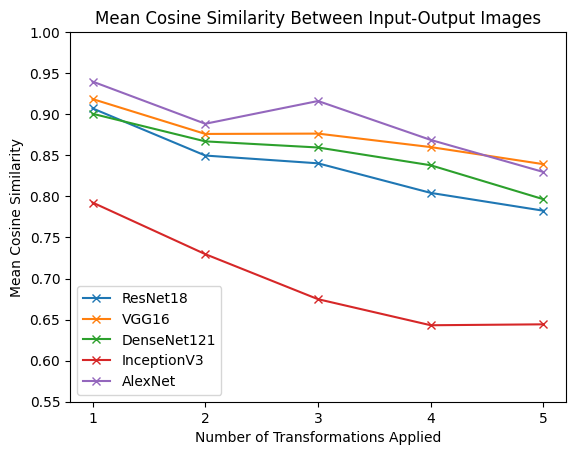

In [84]:
for k, v in vizdict.items():
    plt.plot([0, 1, 2, 3, 4], v, label=k, linestyle='-', marker='x')

plt.xlabel("Number of Transformations Applied")
plt.ylabel("Mean Cosine Similarity")
plt.title("Mean Cosine Similarity Between Input-Output Images")
plt.ylim(0.55, 1)
plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
plt.legend(loc='lower left')
plt.show()